# Installing dependencies

In [1]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

# Imports

In [2]:
import os
import random

#Data
import numpy as np
import pandas as pd
import re
import json
import math

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

# Models
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import umap
from sklearn.decomposition import PCA
from node2vec import Node2Vec

#Metrics
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#Transformations
from sklearn.preprocessing import normalize
import networkx as nx
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from collections import Counter
from sklearn.model_selection import train_test_split
import ast

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-07-22 09:54:37.823953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753178077.993793      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753178078.045074      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data

def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""
    print("Cleaning text")
    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
def get_segments(text: str, max_tokens = 200) -> list[str]:
    """Semantic segmentation of text using gpt 4o"""
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    print("Doing semantic segmentation...")
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": text}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
def generate_embeddings(texts: list[str]) -> list[list[np.ndarray]]:
    print("Generating embeddings for each segmentation")
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

# Knowledge injecting using node graphs

In [7]:
IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])


del organizations['United Nations (UN)']

In [8]:
top_voting = pd.read_csv("/kaggle/input/topic-grouped-voting-data/Voting Data.csv")
top_voting.head()

,Unnamed: 0,countries,text,topic,new_topic
0,0,"['Belgium', 'Canada', 'China', 'Cuba', 'Domini...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
1,1,"['Australia', 'France', 'Israel', 'New Zealand...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
2,2,"['Afghanistan', 'Albania', 'Argentina', 'Austr...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
3,3,"['Cambodia', 'Costa Rica', 'Cuba', 'Ecuador', ...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1122 (XI),United Nations Operations
4,4,"['Albania', 'Bulgaria', 'Belarus', 'nan', 'Hun...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1122 (XI),United Nations Operations


In [9]:
voting = pd.read_csv("/kaggle/input/un-grouped-voting-data/Voting Data Groupings.csv")
voting["countries"] = voting["countries"].fillna('')
voting["countries"] = voting["countries"].apply(lambda x: x.split(";") if x else [])

votings = {voting.iloc[i]['resolution'] : voting.iloc[i]['countries'] for i in range(len(voting))}

In [10]:
voting.head()

,resolution,countries
0,A/RES/10(I),"[Argentina, Australia, Belgium, Bolivia, Brazi..."
1,A/RES/100(I),"[Australia, Egypt, El Salvador, Iraq, Lebanon,..."
2,A/RES/100(I),"[Afghanistan, Argentina, Belgium, Bolivia, Bra..."
3,A/RES/1000(ES-I),"[Albania, Australia, Bulgaria, Belarus, nan, E..."
4,A/RES/1000(ES-I),"[Afghanistan, Argentina, Austria, Belgium, Bol..."


In [11]:
socioeconomic = pd.read_csv("/kaggle/input/countries-of-the-world-2023/world-data-2023.csv")
socioeconomic = socioeconomic.rename(columns={'Country':'countries'})
socioeconomic = socioeconomic.drop(columns=[
    'Abbreviation',
    'Calling Code',
    'Capital/Major City',
    'Currency-Code',
    'Largest city',
    'Minimum wage',
    'Maternal mortality ratio',
    'Tax revenue (%)',
    'CPI Change (%)'
])
socioeconomic = socioeconomic.dropna()
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('%',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace(',',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('$',''))

categorical = socioeconomic[['countries','Official language']]
socioeconomic = socioeconomic.drop(columns=['Official language'])

In [12]:
country_name_map = {
    'The Gambia': 'Gambia',
    'Gambia': 'Gambia',
    'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Equatorial Guinea': 'Equatorial Guinea',
    'Timor-Leste': 'East Timor',
    'East Timor': 'East Timor',
    'Ivory Coast': "Côte d'Ivoire",
    "Côte d'Ivoire": "Côte d'Ivoire",
    'Republic of Ireland': 'Ireland',
    'Republic of the Congo': 'Republic of the Congo',
    'Congo (Brazzaville)': 'Republic of the Congo',
    'The Bahamas': 'Bahamas',
    'Bahamas': 'Bahamas',
    'Eswatini': 'Eswatini',
    'European Union': None,  
    'Sahrawi Arab Democratic Republic': None, 
    'Cabo Verde': 'Cape Verde',
    'nan': None,
    'Niue': None,
    'Bolivia, Plurinational State of': 'Bolivia',
    None: None
}

def standardize_country_name(country_name):
    if country_name in country_name_map:
        return country_name_map[country_name]
    else:
        return country_name

def standardize_organizations(organizations_dict):
    standardized_orgs = {}    
    for org_name, member_countries in organizations_dict.items():
        standardized_members = []
        for country in member_countries:
            standardized = standardize_country_name(country)
            if standardized is not None and standardized not in standardized_members:
                standardized_members.append(standardized)
        standardized_orgs[org_name] = sorted(standardized_members)
    
    return standardized_orgs

def clean_dict(dicti):
    standardized_organizations = standardize_organizations(dicti)
    return standardized_organizations

organizations = clean_dict(organizations)
votings = clean_dict(votings)

In [13]:
all_countries = []
for members in votings.values():
    all_countries.extend(members)

country_counts = Counter(all_countries)

voting_countries = []
for country, count in country_counts.most_common(200):
    voting_countries.append(country)

socioeconomic_countries = list(socioeconomic['countries'])

org_countries = []
all_countries = []
for members in organizations.values():
    all_countries.extend(members)

country_counts = Counter(all_countries)

for country, count in country_counts.most_common(200):
    org_countries.append(country)

not_included_countries = list(set([
    country for country in socioeconomic_countries
    if country not in org_countries or country not in voting_countries
] + [
    country for country in voting_countries
    if country not in org_countries or country not in socioeconomic_countries
] + [
    country for country in org_countries
    if country not in socioeconomic_countries or country not in voting_countries
]))
len(not_included_countries)

53

In [14]:
meta_df = socioeconomic.set_index('countries')
X = meta_df
X_scaled = StandardScaler().fit_transform(X)

sim_matrix = cosine_similarity(X_scaled)

countries = list(meta_df.index)

Computing transition probabilities:   0%|          | 0/193 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 150/150 [00:27<00:00,  5.36it/s]


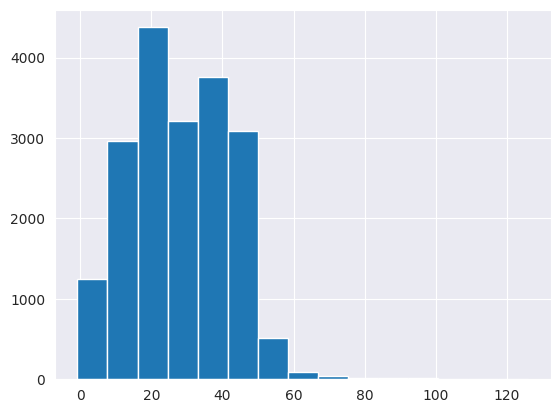

In [15]:
edge_counter = Counter()

imp_org = [
    "European Union (EU)",
    "North Atlantic Treaty Organization (NATO)",
    "Shanghai Cooperation Organisation (SCO)",
    "BRICS",
    "G7",
    "G20",
    "Non-Aligned Movement (NAM)",
    "Organization of Islamic Cooperation (OIC)",
    "G77"
]

for org_name, members in organizations.items():
    if org_name in imp_org:
        org_weight = 10 / len(members) * 3
    else:
        org_weight = 10 / len(members)
    for pair in combinations(members, 2):
        edge_counter[pair] += org_weight*10

for members in votings.values():
    for pair in combinations(members, 2):
        edge_counter[pair] += 0.01

for i, country_i in enumerate(countries):
    for j in range(i+1, len(countries)):
        country_j = countries[j]
        similarity = sim_matrix[i][j]
        edge_counter[(country_i, country_j)] += similarity

plt.hist(dict(edge_counter).values(), bins=15)

G = nx.Graph()
for (u, v), w in edge_counter.items():
    G.add_edge(u, v, weight=w)

countries_to_remove = [
    "Serbia", "Cook Islands", "Ivory Coast", 
    "The Bahamas", "The Gambia", "Republic of Ireland"
]

G.remove_nodes_from(countries_to_remove)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, 
                    p=1, q=0.25, weight_key='weight', workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

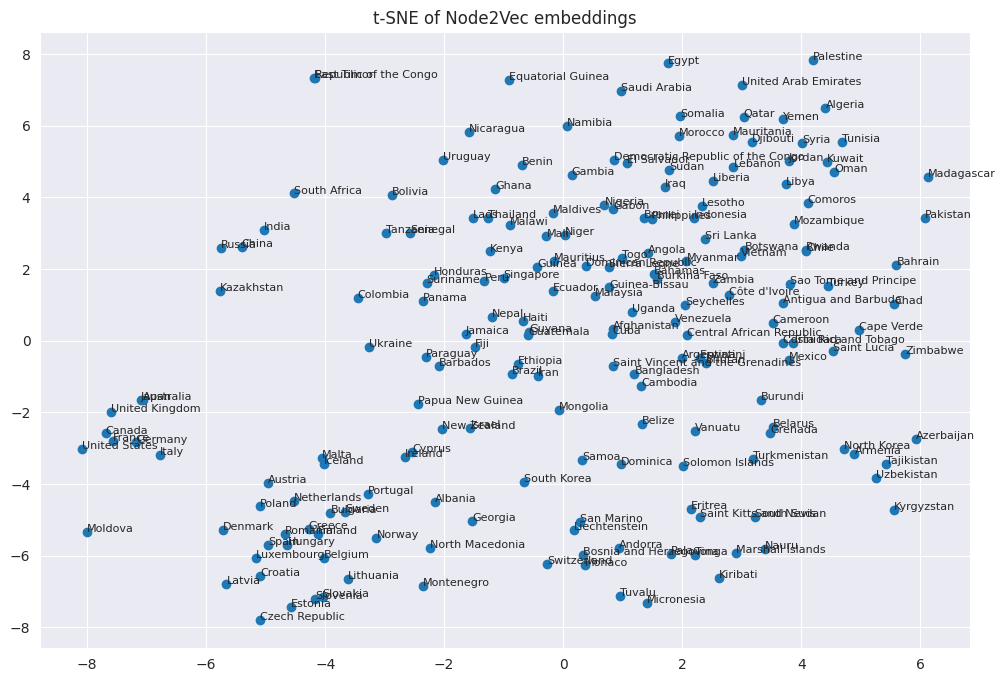

In [16]:
vecs = np.array([model.wv[country] for country in model.wv.index_to_key])
labels = model.wv.index_to_key

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(vecs)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("t-SNE of Node2Vec embeddings")
plt.show()

In [17]:
def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

# Importing Averaged Country Speech Embeddings

In [18]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

df = df.drop(columns=['Holy See (Vatican City State)'])
df = df.rename(columns={'Viet Nam': 'Vietnam',
                        'Brunei Darussalam': 'Brunei',
                        'Iran, Islamic Republic of': 'Iran',
                        "Lao People's Democratic Republic": 'Laos',
                        'Türkiye': 'Turkey',
                        'Syrian Arab Republic': 'Syria',
                        'Russian Federation': 'Russia',
                        'Palestine, State of': 'Palestine',
                        'Korea, Republic of': 'South Korea',
                        "Korea, Democratic People's Republic of": 'North Korea',
                        'Bolivia, Plurinational State of': 'Bolivia',
                        'Moldova, Republic of': 'Moldova',
                        'Tanzania, United Republic of': 'Tanzania',
                        'Micronesia, Federated States of':'Micronesia',
                        'Venezuela, Bolivarian Republic of': 'Venezuela',
                        'Cabo Verde':'Cape Verde',
                        'Timor-Leste': 'East Timor',
                        'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
                        'Czechia': 'Czech Republic',
                        'Congo': 'Republic of the Congo'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

print("In model")
for i in list(model.wv.key_to_index.keys()):
    if not i in df.columns:
        print(i)

In model


In [19]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

graph_data = np.array(graph_data)
speech_data = np.array(speech_data)

# Combining speech embeddings and knowledge based embeddings

In [20]:
cl_speeches = pd.read_pickle("/kaggle/input/embedded-speeches/Make dataset (1).pkl")
cl_speeches = cl_speeches.drop(columns=['country1', 'country2', 'year'])
print(len(cl_speeches))
cl_speeches = cl_speeches.dropna()
print(len(cl_speeches))
cl_speeches['alignment_score'] = cl_speeches['alignment_score'] * 2 - 1

class EmbeddingPairDataset(Dataset):
    def __init__(self, cl_speeches):
        self.emb1 = cl_speeches["speech1"].tolist()
        self.emb2 = cl_speeches["speech2"].tolist()
        self.scores = cl_speeches["alignment_score"].astype(float).tolist()
        self.emb1 = [i.tolist() for i in self.emb1]
        self.emb2 = [i.tolist() for i in self.emb2]
        self.emb1 = torch.tensor(self.emb1, dtype=torch.float32)
        self.emb2 = torch.tensor(self.emb2, dtype=torch.float32)
        self.scores = torch.tensor(self.scores, dtype=torch.float32)

    def __len__(self):
        return len(self.scores)
    def __getitem__(self, idx):
        return self.emb1[idx], self.emb2[idx], self.scores[idx]

train_data, val_data = train_test_split(cl_speeches, test_size=0.2, random_state=42)
dataset = EmbeddingPairDataset(train_data)
val_dataset = EmbeddingPairDataset(val_data)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

20000
20000


In [21]:
def generate_triplets_from_graph_subset(graph_data, indices_subset, num_triplets=1024, pos_k=5, neg_k=5) -> list[set]:
    """Generates triplet data from graph subset for contrastive learning"""
    graph_subset = graph_data[indices_subset]
    graph_dists = pairwise_distances(graph_subset, metric='euclidean')
    n = graph_dists.shape[0]
    triplets = []

    for _ in range(num_triplets):
        anchor = np.random.randint(n)
        sorted_idx = np.argsort(graph_dists[anchor])
        pos_candidates = sorted_idx[1:pos_k+1]
        neg_candidates = sorted_idx[-neg_k:]

        if len(pos_candidates) == 0 or len(neg_candidates) == 0:
            continue

        positive = np.random.choice(pos_candidates)
        negative = np.random.choice(neg_candidates)

        triplets.append((indices_subset[anchor], indices_subset[positive], indices_subset[negative]))

    return triplets

def cosine_similarity_loss(x,y,target_sim):
    cos_sim = F.cosine_similarity(x,y)
    return F.mse_loss(cos_sim, target_sim)

In [22]:
class SpeechEncoder(nn.Module):
    def __init__(self, speech_dim=4096, output_dim=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(speech_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, speech_emb):
        x = self.encoder(speech_emb)
        return self.layer_norm(x)

model = SpeechEncoder(
    speech_dim=speech_data.shape[1],
    output_dim=512
)

model.to(device)

SpeechEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

## First stage of training
Using embedded speeches to do contrastive learning: Positive pairs are countries' speeches whose graph embeddings are close.

------------------------------
           Training
------------------------------


Training epoch 1 | Batch: 100%|██████████| 500/500 [00:02<00:00, 228.99it/s]


Epoch: 001 | Train Loss: 1.16564 | Val Loss: 1.21794


Training epoch 2 | Batch: 100%|██████████| 500/500 [00:01<00:00, 273.85it/s]


Epoch: 002 | Train Loss: 1.22357 | Val Loss: 1.21794


Training epoch 3 | Batch: 100%|██████████| 500/500 [00:01<00:00, 274.30it/s]


Epoch: 003 | Train Loss: 1.22357 | Val Loss: 1.21794


Training epoch 4 | Batch: 100%|██████████| 500/500 [00:01<00:00, 269.35it/s]


Epoch: 004 | Train Loss: 1.22357 | Val Loss: 1.21794


Training epoch 5 | Batch: 100%|██████████| 500/500 [00:01<00:00, 269.94it/s]


Epoch: 005 | Train Loss: 1.22357 | Val Loss: 1.21794


Training epoch 6 | Batch: 100%|██████████| 500/500 [00:01<00:00, 266.75it/s]


Epoch: 006 | Train Loss: 1.22357 | Val Loss: 1.21794
Stopping early at epoch 6
------------------------------
           Results
------------------------------
Final Val Loss: 1.2179
Initial Loss: 1.1965
Percent Improvement: -1.7955%


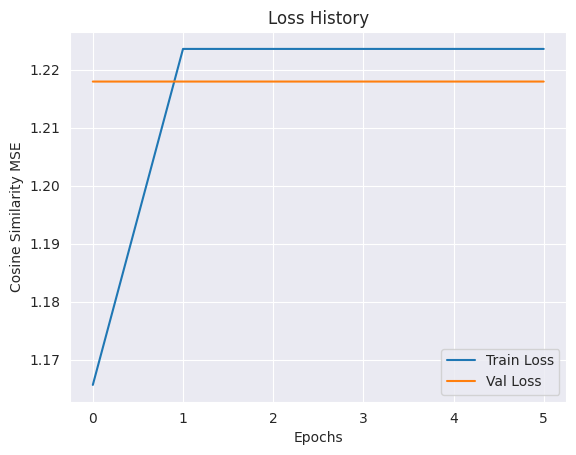

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("-" * 30 + "\n" + " " * 11 + "Training\n" + "-" * 30)

best_loss = float('inf')
patience = 5
wait = 0
val_history = []
train_history = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for a, b, score in dataloader:
        a, b, score = a.to(device), b.to(device), score.to(device)
        proj_a = model(a)
        proj_b = model(b)
        loss = cosine_similarity_loss(proj_a, proj_b, score)
        total_loss += loss.item() * len(score)
    in_loss = total_loss / len(dataset)

for epoch in range(10):
    model.train()
    total_loss = 0
    for a, b, score in tqdm(dataloader, desc=f'Training epoch {epoch+1} | Batch'):
        a, b, score = a.to(device), b.to(device), score.to(device)

        proj_a = model(a)
        proj_b = model(b)
        loss = cosine_similarity_loss(proj_a, proj_b, score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(score)

    train_epoch_loss = total_loss / len(dataset)
    train_history.append(train_epoch_loss)

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for a, b, score in val_dataloader:
            a, b, score = a.to(device), b.to(device), score.to(device)
            proj_a = model(a)
            proj_b = model(b)
            loss = cosine_similarity_loss(proj_a, proj_b, score)
            total_loss += loss.item() * len(score)
        val_epoch_loss = total_loss / len(val_dataset)
        val_history.append(val_epoch_loss)

    print(f"Epoch: {epoch+1:03d} | Train Loss: {train_epoch_loss:.5f} | Val Loss: {val_epoch_loss:.5f}")

    if val_epoch_loss < best_loss - 1e-4:
        best_loss = val_epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

    scheduler.step()

print("-" * 30 + "\n" + " " * 11 + "Results\n" + "-" * 30)
print(f"Final Val Loss: {best_loss:.4f}")
print(f"Initial Loss: {in_loss:.4f}")
print(f"Percent Improvement: {(in_loss - best_loss) / in_loss * 100:.4f}%")

sns.lineplot(x=range(len(train_history)), y=train_history, label='Train Loss')
sns.lineplot(x=range(len(val_history)), y=val_history, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Cosine Similarity MSE")
plt.title("Loss History")
plt.legend()
plt.show()

## Second stage of training
I now use the averaged embedding of all the countries' speeches and graph based embeddings to create positive and negative pairs likewise and train the model further so that the final country embeddings preserve the structure of the graph embeddings.

In [24]:
speech_tensor = torch.tensor(speech_data, dtype=torch.float32)
graph_tensor = torch.tensor(graph_data, dtype=torch.float32)

indices = np.arange(len(speech_data))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

num_epochs = 100
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    train_triplets = generate_triplets_from_graph_subset(graph_data, train_idx, num_triplets=10000)

    if len(train_triplets) == 0:
        print("No training triplets generated, skipping epoch.")
        continue

    a_idx, p_idx, n_idx = zip(*train_triplets)
    a_idx = torch.tensor(a_idx)
    p_idx = torch.tensor(p_idx)
    n_idx = torch.tensor(n_idx)

    anchor = model(speech_tensor[a_idx].to(device))
    positive = model(speech_tensor[p_idx].to(device))
    negative = model(speech_tensor[n_idx].to(device))

    anchor = F.normalize(anchor, dim=1)
    positive = F.normalize(positive, dim=1)
    negative = F.normalize(negative, dim=1)

    loss = triplet_loss_fn(anchor, positive, negative)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_triplets = generate_triplets_from_graph_subset(graph_data, val_idx, num_triplets=512)
        if len(val_triplets) > 0:
            a_idx, p_idx, n_idx = zip(*val_triplets)
            a_idx = torch.tensor(a_idx)
            p_idx = torch.tensor(p_idx)
            n_idx = torch.tensor(n_idx)

            anchor = model(speech_tensor[a_idx].to(device))
            positive = model(speech_tensor[p_idx].to(device))
            negative = model(speech_tensor[n_idx].to(device))

            anchor = F.normalize(anchor, dim=1)
            positive = F.normalize(positive, dim=1)
            negative = F.normalize(negative, dim=1)

            val_loss = triplet_loss_fn(anchor, positive, negative).item()
        else:
            val_loss = None

    if epoch % 10 == 0 or val_loss is not None:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss}")

    if val_loss is not None:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

Epoch 0, Train Loss: 1.000000, Val Loss: 0.9999998807907104
Epoch 1, Train Loss: 1.000000, Val Loss: 0.9997295141220093
Epoch 2, Train Loss: 0.997387, Val Loss: 0.9864938855171204
Epoch 3, Train Loss: 0.847334, Val Loss: 0.9865995049476624
Epoch 4, Train Loss: 0.874681, Val Loss: 0.9830346703529358
Epoch 5, Train Loss: 0.774452, Val Loss: 0.983842670917511
Epoch 6, Train Loss: 0.675933, Val Loss: 0.9697687029838562
Epoch 7, Train Loss: 0.418757, Val Loss: 0.9524962902069092
Epoch 8, Train Loss: 0.632712, Val Loss: 0.9734302759170532
Epoch 9, Train Loss: 0.515108, Val Loss: 0.9707359075546265
Epoch 10, Train Loss: 0.494367, Val Loss: 0.9809191226959229
Epoch 11, Train Loss: 0.380064, Val Loss: 0.9371717572212219
Epoch 12, Train Loss: 0.356335, Val Loss: 0.8380705118179321
Epoch 13, Train Loss: 0.444672, Val Loss: 0.9090286493301392
Epoch 14, Train Loss: 0.437602, Val Loss: 0.9188910722732544
Epoch 15, Train Loss: 0.387826, Val Loss: 0.9361140727996826
Epoch 16, Train Loss: 0.329625, Val

In [25]:
model.eval()
final_country_embeddings = pd.DataFrame(model(speech_tensor.to(device)).detach().cpu().numpy().transpose())
final_country_embeddings.columns=df.columns

In [26]:
final_country_embeddings.to_csv("Final_Embeddings.csv")

In [27]:
PATH = "state_dict.pth"
torch.save(model.state_dict(), PATH)

In [28]:
def compare_countries(country1, country2, final_country_embeddings):
    cs = euclidean_distances(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

# Visualizing and testing

(193, 128) (193, 4096)


Text(0.5, 1.0, 'Correlation Between Policy - Speech Embeddings')

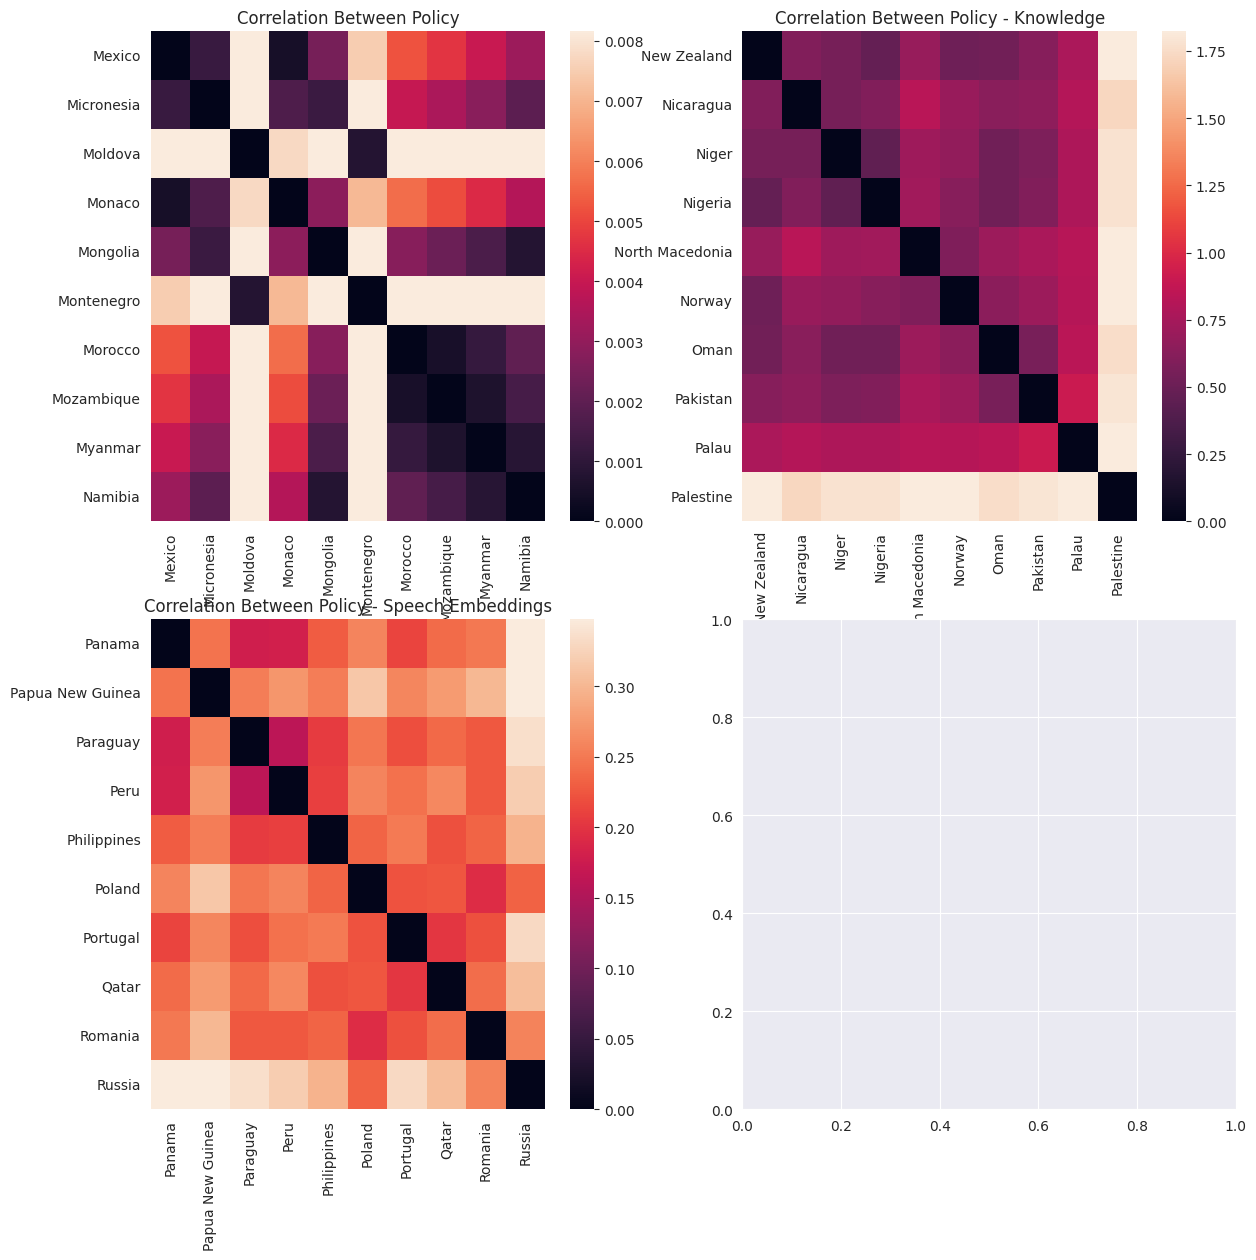

In [29]:
def get_corr_matrix(final_country_embeddings):
    start = random.randint(0, len(final_country_embeddings.columns)-10)
    corr_matrix = pd.DataFrame(
        index=final_country_embeddings.columns[start:start+10],
        columns=final_country_embeddings.columns[start:start+10],
        dtype=float
    )
    for i, country in enumerate(final_country_embeddings.columns[start:start+10]):
        for j, country_2 in enumerate(final_country_embeddings.columns[start:start+10]):
            if j > i:
                sim = compare_countries(country, country_2, final_country_embeddings)
                corr_matrix.loc[country, country_2] = sim
                corr_matrix.loc[country_2, country] = sim
            elif j==i:
                corr_matrix.loc[country, country_2] = 0
    return corr_matrix

corr_matrix = get_corr_matrix(final_country_embeddings)
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

graph_df = pd.DataFrame(graph_data.transpose(), columns=countries)
speech_df = pd.DataFrame(speech_data.transpose(), columns=countries)

graph_df = get_corr_matrix(graph_df)
speech_df = get_corr_matrix(speech_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

minmax = 5

sns.heatmap(corr_matrix, annot=False, vmin=min([item for sublist in [[[a for i, a in corr_matrix.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), vmax=max([item for sublist in [[[a for i, a in corr_matrix.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), ax=axes[0])
axes[0].set_title('Correlation Between Policy')

sns.heatmap(graph_df, annot=False, vmin=min([item for sublist in [[[a for i, a in graph_df.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), vmax=max([item for sublist in [[[a for i, a in graph_df.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), ax=axes[1])
axes[1].set_title('Correlation Between Policy - Knowledge')

sns.heatmap(speech_df, annot=False, vmin=min([item for sublist in [[[a for i, a in speech_df.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), vmax=max([item for sublist in [[[a for i, a in speech_df.items()][0][j] for i in range(10)] for j in range(10)] for item in sublist]), ax=axes[2])
axes[2].set_title('Correlation Between Policy - Speech Embeddings')

# Testing Model

In [30]:
def normalize(vecs):
    return vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

def generate_country_similarity(speech: str, place: str, df):
    clean_speech = clean_text(speech)
    speech_segments = get_segments(clean_speech)
    speech_embeddings = np.array(generate_embeddings(speech_segments))
    av_vec = np.mean(speech_embeddings, axis=0)
    
    av_vec = np.expand_dims(av_vec, axis=0) 

    model.eval()
    with torch.no_grad():
        speech_emb = torch.tensor(av_vec).float().to(device)

        place_idx = list(df.columns).index(place)
        graph_emb_np = pca_graph[place_idx] 
        graph_emb = torch.tensor(graph_emb_np).float().unsqueeze(0) 
        fused_output = model(speech_emb).cpu()
        print(fused_output.shape)
        fused_vec = fused_output.squeeze(0).numpy() 

    country_names = list(final_country_embeddings.columns)

    country_matrix = []
    for country in country_names:
        # speech embedding for country
        speech_idx = country_names.index(country)
        speech_vec = speech_tensor[speech_idx].numpy()
        graph_vec = torch.tensor(pca_graph, dtype=torch.float32)[speech_idx].numpy()
        combined_vec = final_country_embeddings[country]
        country_matrix.append(combined_vec)
    country_matrix = np.stack(country_matrix)

    fused_vec_norm = fused_vec / np.linalg.norm(fused_vec)
    print(country_matrix.shape)
    similarities = euclidean_distances([fused_vec_norm], np.squeeze(country_matrix))[0]

    sorted_data = sorted(zip(similarities, country_names), key=lambda x: x[0], reverse=False)

    for sim, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{sim:.6f} — {country}")
            if sim > 0.8:
                print("You did a great job in policy alignment!!!")
            print("\n\n")
        else:
            print(f"{sim:.6f} — {country}")

In [31]:
def get_country_stats(country: str) -> None:
    """Prints socioeconomic statistics of the country"""
    print(f"Socioeconomic statistics of {country} as of 2023")
    country_data = pd.DataFrame(socioeconomic[socioeconomic['countries']==country]).drop(columns=['countries']).rename(columns={'Density\n(P/Km2)': 'Density (P/Km2)'})
    print(''.join(f"   - {column}: {country_data.iloc[0][column]}\n" for column in country_data.columns))

In [32]:
pca = PCA(n_components=128)
pca_graph = pca.fit_transform(graph_data)  # graph_data now has shape (num_samples, 20)

In [33]:
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(f"Policy similarities of speech:\n\n{MUN_speeches.loc[index]['Speech']} \n\nFrom delegate of nation: {MUN_speeches.loc[index]['Country']}\n\n")
print(f"\nBasic information about {MUN_speeches.loc[index]['Country']}:\n")
print(f"{MUN_speeches.loc[index]['Country']} is part of the following organizations")
print("".join(f"   - {organization}\n" for organization in get_organizations(MUN_speeches.loc[index]['Country'])))

get_country_stats(MUN_speeches.loc[index]['Country'])
country = MUN_speeches.loc[index]['Country']
if country == 'DPRK':
    country = 'North Korea'
if country == "USA":
    country = 'United States'
generate_country_similarity(MUN_speeches.loc[index]['Speech'], country, df)

Policy similarities of speech:

Since the Central African Republic’s independence in 1960, resilience has drastically shaped our nation. We stand before this assembly to address problems such as sociocultural grievance driven protests, which have necessitated policies banning political demonstrations to limit civil unrest, violence and other heinous acts. While controversial, these measures have been crucial for political stability. We also acknowledge issues within our peacekeeping forces, including systemic flaws and abuses, and have sought international supervision from observer organizations to address these cases. Water deprivation in war torn regions remains an imperative concern, exacerbated by recent conflicts. Short-term solutions like sand dams and temporary wells have proven effective, and the Central African Republic is fervent in providing insight on said issues. Finally, regarding Haiti's gang violence, we sympathize with those struggling, as we’ve faced similar struggles

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 512])
(193, 512)
0.882475 — Democratic Republic of the Congo
0.882794 — Equatorial Guinea
0.883141 — Republic of the Congo
0.883182 — Guinea-Bissau
0.883211 — Mali
0.883357 — Guinea
0.883381 — Benin
0.883400 — Zambia
0.883430 — Cameroon
0.883554 — Senegal
0.883590 — Zimbabwe
0.883717 — Gabon


-----Central African Republic------


0.883815 — Central African Republic
You did a great job in policy alignment!!!



0.883883 — Panama
0.883890 — Tanzania
0.883952 — Côte d'Ivoire
0.884021 — Uganda
0.884041 — Sierra Leone
0.884046 — Burundi
0.884118 — Laos
0.884219 — Eswatini
0.884288 — Angola
0.884367 — Burkina Faso
0.884367 — Chad
0.884424 — Niger
0.884582 — Sudan
0.884654 — Malawi
0.884744 — Bhutan
0.884750 — Rwanda
0.884766 — Kuwait
0.884929 — Barbados
0.884944 — Lesotho
0.884962 — Gambia
0.884965 — Morocco
0.884971 — Comoros
0.884975 — Botswana
0.885142 — Haiti
0.885296 — Mauritania
0.885313 — Kenya
0.885360 — Algeria
0.885366 — Nigeria
0.885394 — Ghana
0.885409 — Mozambiqu